In [1]:
#read in relevant packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs #for plotting
import numpy as np #for plotting
import geocat.viz as gv #for plotting

##for animation
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

##dates
import datetime

##from wrf-python examples
#from __future__ import print_function
#from netCDF4 import Dataset
#from wrf import getvar

#to get a list of the files in the folder
import glob 

##attempt to reformat the netcdf in one line
import xwrf

Now we need to pull in the relecant datasets, which are in two folders (Houston_MarineHeatWave_2016, Houston_MarineHeatWave_2017). I am going to ingnore the first morning because the model needs to spin up a bit, and we are going to focus on the smaller domain (domain 2) 

Option 1: https://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/WRF/wrf_ex.html#:~:text=We%20encourage%20scientists%20to%20use,is%20still%20compatible%20with%20Xarray
* not sure where to get the right input file for the coordinates though...

Option 2: Might be able to use wrf-python to read the wrfout files directly? https://github.com/NCAR/wrf-python
* need to make sure you can get CF-compliant netCDF files, and that is not clear to me
* have a dependencies issue here, need python 3.12.* but there is not a version of wrf-python for 3.12.*

Option 3: Try with xwrf (seems elegant): https://xarray.dev/blog/introducing-xwrf
* Seems to work, going to see if can merge them: https://stackoverflow.com/questions/47226429/join-merge-multiple-netcdf-files-using-xarrays

In [3]:
#start with 2016 data
d02_2016_names = glob.glob("../Houston_MarineHeatWave_2016/wrfout_MarineHeatWave.d02.*")

#Due to memory limitations, going to try doing it in groups 3 days at a time)
#4-15
#16 - 27
#28 - 39
#40 - 50

#still getting memory errors, maybe try merging after selecting T2?

##Starting with group 1
initial_ds = xr.open_dataset(d02_2016_names[4]).xwrf.postprocess()
#initial_ds
initial_2mTemp = initial_ds.T2
merged_2mTemp = initial_2mTemp
for file in d02_2016_names[5:]:
    ds = xr.open_dataset(file).xwrf.postprocess() #need to specify netcdf4 maybe? 
    ds_2mTemp = ds.T2
    merged_2mTemp = xr.merge([merged_2mTemp, ds_2mTemp])


Now get to go to the visualization

Note, you probably want to skip the first 12 hours because there is a necessary spin-up period. 

In [27]:
#merged_2mTemp #to be able to see the attributes

#min_lat = merged_2mTemp.XLAT.min()
#max_lat = merged_2mTemp.XLAT.max()
#min_lon = merged_2mTemp.XLONG.min()
#max_lon = merged_2mTemp.XLONG.max()

#print([min_lon, max_lon, min_lat, max_lat])

maplimits = [-96.6, -94.1, 28.8, 30.6] # need to update this to match the new domain edges
merged_2mTemp #to be able to see the attributes

<xarray.Dataset> Size: 58MB
Dimensions:  (Time: 276, x: 230, y: 225)
Coordinates:
  * Time     (Time) datetime64[ns] 2kB 2016-03-24 ... 2016-04-04T11:00:00
  * x        (x) float64 2kB -1.145e+05 -1.135e+05 ... 1.135e+05 1.145e+05
  * y        (y) float64 2kB 2.948e+06 2.949e+06 ... 3.171e+06 3.172e+06
    XLAT     (y, x) float32 207kB 28.71 28.71 28.71 28.71 ... 30.69 30.69 30.69
    XLONG    (y, x) float32 207kB -96.51 -96.5 -96.49 ... -94.2 -94.19 -94.18
    XTIME    (Time) datetime64[ns] 2kB 2016-03-24 ... 2016-04-04T11:00:00
    CLAT     (y, x) float32 207kB 28.71 28.71 28.71 28.71 ... 30.69 30.69 30.69
Data variables:
    T2       (Time, y, x) float32 57MB 293.6 293.1 292.9 ... 276.3 276.4 277.4
Attributes:
    FieldType:      104
    MemoryOrder:    XY 
    description:    TEMP at 2 M
    units:          K
    stagger:        
    standard_name:  air_temperature
    long_name:      air_temperature_at_2m_agl
    grid_mapping:   wrf_projection

Text(0, 0.5, '')

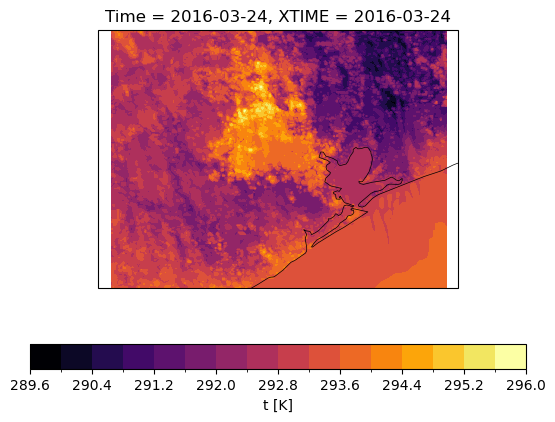

In [32]:
fig = plt.figure()

# explicitly set up axis with projection
ax = plt.axes(projection=ccrs.PlateCarree())

# add coastlines
ax.coastlines(linewidths=0.5)
ax.set_extent([maplimits[0], maplimits[1],maplimits[2],maplimits[3]], ccrs.PlateCarree())

init_Time = merged_2mTemp.isel(Time=0)
#merged_2mTemp[0, :, :].plot.contourf(ax=ax,
init_Time.T2.plot.contourf(ax=ax,
                           transform= ccrs.PlateCarree(),
                           levels=20,
                           x = "XLONG", 
                           y="XLAT",
                           cmap="inferno",
                           cbar_kwargs={
                               "orientation": "horizontal",
                               "label": "t [K]"}
                            )

# configure axes
maplimits = [-96.6, -94.1, 28.8, 30.6] 
ax.set_xlabel("")
#ax.set_xticks(np.arange(maplimits[0], maplimits[1], 10))

ax.set_ylabel("")
#ax.set_yticks(np.arange(maplimits[2], maplimits[3], 10));

Now we get to trying to create the changing gif

In [74]:
##Trying to figure out the dates for the names of the plots
DatesList = merged_2mTemp.coords['Time'].values
MonthsList = []
DaysList = []
HourList = []

for dt in DatesList:
    full = datetime.datetime.strptime(str(dt.astype('datetime64[D]')), "%Y-%m-%d")
    MonthsList.append(full.month)
    DaysList.append(full.day)
    hrs = pd.Timestamp(dt)
    HourList.append(hrs.hour)

#print(MonthsList)
#print(DaysList)
#print(HourList)
len(HourList)

276

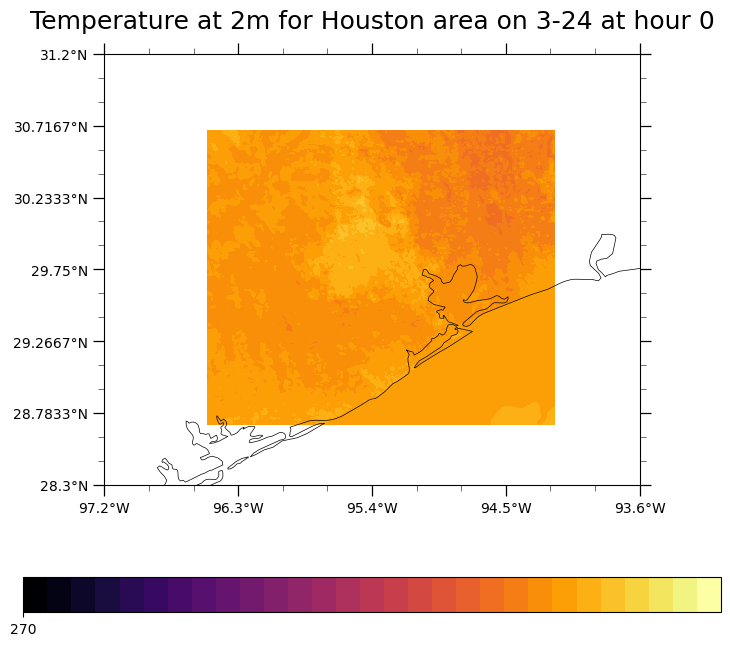

In [77]:
fig = plt.figure(figsize=(10, 8))

maplimits = [-97.2, -93.6, 28.3, 31.2]

# Generate axes using Cartopy and draw coastlines
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= 0))
ax.coastlines(linewidths=0.5)

ax.set_extent([maplimits[0], maplimits[1],maplimits[2],maplimits[3]], ccrs.PlateCarree())

# Use geocat-viz convenience function to set axes limits & tick values
gv.set_axes_limits_and_ticks(ax,
                             xlim=(maplimits[0], maplimits[1]),
                             ylim=(maplimits[2], maplimits[3]),
                             xticks=np.linspace(maplimits[0], maplimits[1], 5),
                             yticks=np.linspace(maplimits[2], maplimits[3], 7))

# Use geocat-viz convenience function to add minor and major tick lines
gv.add_major_minor_ticks(ax, labelsize=10)

# Use geocat-viz convenience function to make latitude, longitude tick labels
gv.add_lat_lon_ticklabels(ax)

# Create initial plot
cplot = merged_2mTemp.isel(Time=0).T2.plot.contourf(ax=ax,
                                   transform=ccrs.PlateCarree(),
                                   vmin=270,
                                   vmax=300,
                                   x = "XLONG", 
                                   y="XLAT",
                                   levels=30,
                                   cmap="inferno",
                                   add_colorbar=False)

# Create a colorbar
cbar = fig.colorbar(cplot,
                    extendrect=True,
                    orientation="horizontal",
                    ticks=np.arange(270, 300, 30),
                    label="",
                    shrink=0.90)

# Remove minor ticks from colorbar that don't work well with other formatting
cbar.ax.minorticks_off()


# Animate function for matplotlib FuncAnimation
def animate(i):
    merged_2mTemp.isel(Time=i).T2.plot.contourf(ax=ax,
                               transform=ccrs.PlateCarree(),
                               vmin=270,
                               vmax=300,
                               x = "XLONG", 
                               y="XLAT",
                               levels=30,
                               cmap="inferno",
                               add_colorbar=False)

    gv.set_titles_and_labels(
        ax,
        maintitle=("Temperature at 2m for Houston area on " + str(MonthsList[i]) + 
                   "-" + str(DaysList[i]) + " at hour " + str(HourList[i])),
        xlabel="",
        ylabel="")

# Run the animation initiated with the frame from init and progressed with the animate function
anim = animation.FuncAnimation(fig, animate, frames=275, interval=200)

# Uncomment this line to save the animation
anim.save('animate_2016_2mTemp.gif', writer='pillow', fps=3)

Now we do the same thing for 2017

In [78]:
d02_2017_names = glob.glob("../Houston_MarineHeatWave_2017/wrfout_MarineHeatWave.d02.*")

##Starting with group 1
initial_ds = xr.open_dataset(d02_2017_names[4]).xwrf.postprocess()
#initial_ds
initial_2mTemp17 = initial_ds.T2
merged_2mTemp17 = initial_2mTemp
for file in d02_2017_names[5:]:
    ds = xr.open_dataset(file).xwrf.postprocess() #need to specify netcdf4 maybe? 
    ds_2mTemp = ds.T2
    merged_2mTemp17 = xr.merge([merged_2mTemp17, ds_2mTemp])


Skip straight to the animation

IndexError: index 276 is out of bounds for axis 0 with size 276

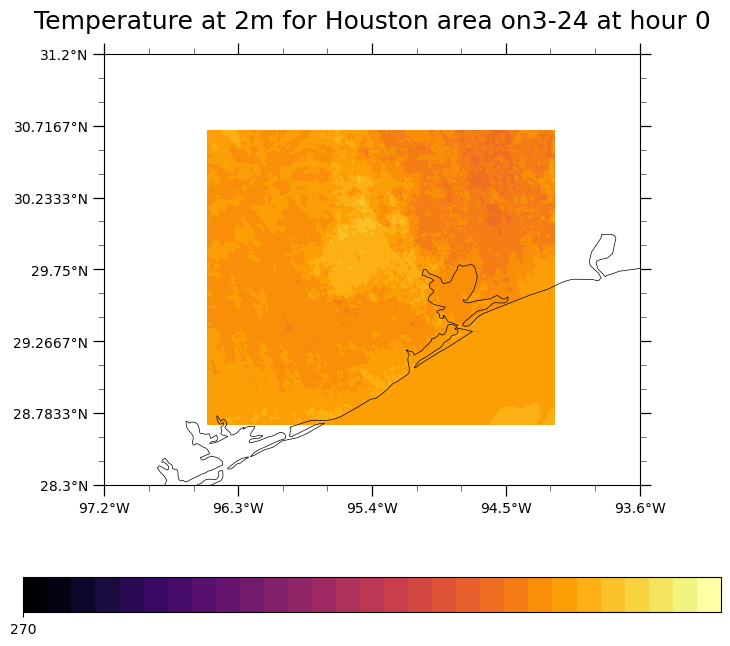

In [79]:
##Trying to figure out the dates for the names of the plots
DatesList = merged_2mTemp17.coords['Time'].values
MonthsList = []
DaysList = []
HourList = []

for dt in DatesList:
    full = datetime.datetime.strptime(str(dt.astype('datetime64[D]')), "%Y-%m-%d")
    MonthsList.append(full.month)
    DaysList.append(full.day)
    hrs = pd.Timestamp(dt)
    HourList.append(hrs.hour)

fig = plt.figure(figsize=(10, 8))

maplimits = [-97.2, -93.6, 28.3, 31.2]
DatesList = merged_2mTemp17.coords['Time'].values
DatesMonth = DatesList.astype('datetime64[M]').astype(int) % 12 + 1
DatesDays = DatesList - DatesList.astype('datetime64[M]') + 1

# Generate axes using Cartopy and draw coastlines
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= 0))
ax.coastlines(linewidths=0.5)

ax.set_extent([maplimits[0], maplimits[1],maplimits[2],maplimits[3]], ccrs.PlateCarree())

# Use geocat-viz convenience function to set axes limits & tick values
gv.set_axes_limits_and_ticks(ax,
                             xlim=(maplimits[0], maplimits[1]),
                             ylim=(maplimits[2], maplimits[3]),
                             xticks=np.linspace(maplimits[0], maplimits[1], 5),
                             yticks=np.linspace(maplimits[2], maplimits[3], 7))

# Use geocat-viz convenience function to add minor and major tick lines
gv.add_major_minor_ticks(ax, labelsize=10)

# Use geocat-viz convenience function to make latitude, longitude tick labels
gv.add_lat_lon_ticklabels(ax)

# Create initial plot
cplot = merged_2mTemp17.isel(Time=0).T2.plot.contourf(ax=ax,
                                   transform=ccrs.PlateCarree(),
                                   vmin=270,
                                   vmax=300,
                                   x = "XLONG", 
                                   y="XLAT",
                                   levels=30,
                                   cmap="inferno",
                                   add_colorbar=False)

# Create a colorbar
cbar = fig.colorbar(cplot,
                    extendrect=True,
                    orientation="horizontal",
                    ticks=np.arange(270, 300, 30),
                    label="",
                    shrink=0.90)

# Remove minor ticks from colorbar that don't work well with other formatting
cbar.ax.minorticks_off()


# Animate function for matplotlib FuncAnimation
def animate(i):
    merged_2mTemp17.isel(Time=i).T2.plot.contourf(ax=ax,
                               transform=ccrs.PlateCarree(),
                               vmin=270,
                               vmax=300,
                               x = "XLONG", 
                               y="XLAT",
                               levels=30,
                               cmap="inferno",
                               add_colorbar=False)

    gv.set_titles_and_labels(
        ax,
        maintitle=("Temperature at 2m for Houston area on" + str(MonthsList[i]) + 
                   "-" + str(DaysList[i]) + " at hour " + str(HourList[i])),
        xlabel="",
        ylabel="")

# Run the animation initiated with the frame from init and progressed with the animate function
anim = animation.FuncAnimation(fig, animate, frames=275, interval=200)

# Uncomment this line to save the animation
anim.save('animate_2017_2mTemp.gif', writer='pillow', fps=3)

Look at the outputs from the SST interpolation to see if they make sense
* ../LIBRARIES/WPS/met_em.d02.2021-10-25_060000.nc

In [2]:
ds = xr.open_dataset('../LIBRARIES/WPS/met_em.d02.2021-10-25_060000.nc').xwrf.postprocess() #need to specify netcdf4 maybe? 
ds

<xarray.Dataset> Size: 247MB
Dimensions:         (Time: 1, num_metgrid_levels: 40, y: 333, x: 351,
                     num_st_layers: 4, y_stag: 334, x_stag: 352,
                     z-dimension0132: 132, z-dimension0012: 12,
                     z-dimension0016: 16, z-dimension0021: 21)
Coordinates: (12/15)
    XLONG_C         (y_stag, x_stag) float32 470kB -97.25 -97.24 ... -93.61
    XLAT_C          (y_stag, x_stag) float32 470kB 28.26 28.26 ... 31.26 31.26
    CLONG           (y, x) float32 468kB -97.25 -97.24 -97.23 ... -93.62 -93.61
    CLAT            (y, x) float32 468kB 28.27 28.27 28.27 ... 31.26 31.26 31.26
    XLONG_U         (y, x_stag) float32 469kB -97.25 -97.24 ... -93.62 -93.61
    XLAT_U          (y, x_stag) float32 469kB 28.27 28.27 28.27 ... 31.26 31.26
    ...              ...
    XLAT_M          (y, x) float32 468kB 28.27 28.27 28.27 ... 31.26 31.26 31.26
  * Time            (Time) datetime64[ns] 8B 2021-10-25T06:00:00
  * y               (y) float64 3kB 2.839e+06 2.84e+06 ... 3.17e+06 3.171e+06
  * x               (x) float64 3kB -1.75e+05 -1.74e+05 ... 1.74e+05 1.75e+05
  * x_stag          (x_stag) float64 3kB -1.755e+05 -1.745e+05 ... 1.755e+05
  * y_stag          (y_stag) float64 3kB 2.839e+06 2.84e+06 ... 3.172e+06
Dimensions without coordinates: num_metgrid_levels, num_st_layers,
                                z-dimension0132, z-dimension0012,
                                z-dimension0016, z-dimension0021
Data variables: (12/66)
    Times           (Time) |S19 19B b'2021-10-25_06:00:00'
    PRES            (Time, num_metgrid_levels, y, x) float32 19MB ...
    SOIL_LAYERS     (Time, num_st_layers, y, x) float32 2MB ...
    ST              (Time, num_st_layers, y, x) float32 2MB ...
    SST             (Time, y, x) float32 468kB ...
    GHT             (Time, num_metgrid_levels, y, x) float32 19MB ...
    ...              ...
    MAPFAC_VX       (Time, y_stag, x) float32 469kB ...
    MAPFAC_MX       (Time, y, x) float32 468kB ...
    MAPFAC_U        (Time, y, x_stag) float32 469kB ...
    MAPFAC_V        (Time, y_stag, x) float32 469kB ...
    MAPFAC_M        (Time, y, x) float32 468kB ...
    wrf_projection  object 8B +proj=merc +x_0=0 +y_0=0 +a=6370000 +b=6370000 ...
Attributes: (12/63)
    TITLE:                           OUTPUT FROM METGRID V4.6.0
    SIMULATION_START_DATE:           2021-10-25_06:00:00
    WEST-EAST_GRID_DIMENSION:        352
    SOUTH-NORTH_GRID_DIMENSION:      334
    BOTTOM-TOP_GRID_DIMENSION:       40
    WEST-EAST_PATCH_START_UNSTAG:    1
    ...                              ...
    FLAG_SOILHGT:                    1
    FLAG_MF_XY:                      1
    FLAG_LAI12M:                     1
    FLAG_VAR_SSO:                    1
    FLAG_URB_PARAM:                  1
    FLAG_FRC_URB2D:                  1

Text(0, 0.5, '')

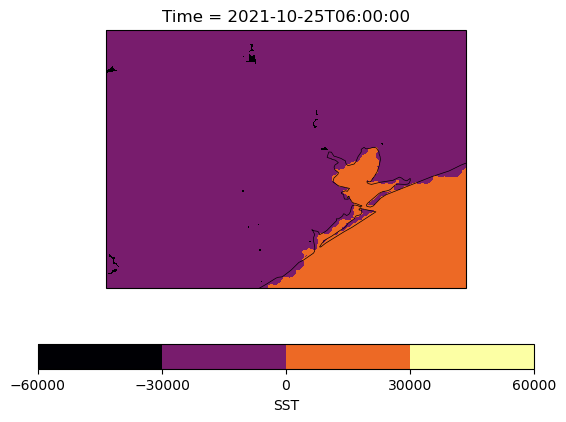

In [12]:
sst_check = ds.SST

maplimits = [-96.6, -94.1, 28.8, 30.6] # need to update this to match the new domain edges

fig = plt.figure()

# explicitly set up axis with projection
ax = plt.axes(projection=ccrs.PlateCarree())

# add coastlines
ax.coastlines(linewidths=0.5)
ax.set_extent([maplimits[0], maplimits[1],maplimits[2],maplimits[3]], ccrs.PlateCarree())

#merged_2mTemp[0, :, :].plot.contourf(ax=ax,
sst_check.isel(Time=0).plot.contourf(ax=ax,
                           transform= ccrs.PlateCarree(),
                           levels=2,
                           x = "XLONG_M", 
                           y="XLAT_M",
                           cmap="inferno",
                           cbar_kwargs={
                               "orientation": "horizontal",
                               "label": "SST"}
                            )

# configure axes
maplimits = [-96.6, -94.1, 28.8, 30.6] 
ax.set_xlabel("")
#ax.set_xticks(np.arange(maplimits[0], maplimits[1], 10))

ax.set_ylabel("")


In [6]:
sst_check

<xarray.DataArray 'SST' (Time: 1, y: 333, x: 351)> Size: 468kB
[116883 values with dtype=float32]
Coordinates:
    CLONG    (y, x) float32 468kB -97.25 -97.24 -97.23 ... -93.63 -93.62 -93.61
    CLAT     (y, x) float32 468kB 28.27 28.27 28.27 28.27 ... 31.26 31.26 31.26
    XLONG_M  (y, x) float32 468kB -97.25 -97.24 -97.23 ... -93.63 -93.62 -93.61
    XLAT_M   (y, x) float32 468kB 28.27 28.27 28.27 28.27 ... 31.26 31.26 31.26
  * Time     (Time) datetime64[ns] 8B 2021-10-25T06:00:00
  * y        (y) float64 3kB 2.839e+06 2.84e+06 2.841e+06 ... 3.17e+06 3.171e+06
  * x        (x) float64 3kB -1.75e+05 -1.74e+05 -1.73e+05 ... 1.74e+05 1.75e+05
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    units:         K
    description:   Sea surface temperature
    stagger:       M
    sr_x:          1
    sr_y:          1
    grid_mapping:  wrf_projection